# Solution Notebook

In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from src.dataset import DishDataset
from collections import Counter


# EDA

## Data Loading and Basic Info

In [2]:
DISH_DF_PATH = './data/dish.csv'
INGR_DF_PATH = './data/ingredients.csv'
IMAGES_ROOT = './data/images'

dish_df = pd.read_csv(DISH_DF_PATH)
ingr_df = pd.read_csv(INGR_DF_PATH)

# Create datasets
train_dataset = DishDataset(dish_df, IMAGES_ROOT, ingr_df, train=True)
test_dataset = DishDataset(dish_df, IMAGES_ROOT, ingr_df, train=False)

print(f'Train size: {len(train_dataset)}')
print(f'Test size: {len(test_dataset)}')


Train size: 2754
Test size: 507


## Missing Images and Text Descriptions

In [3]:
def count_missing(dataset, check_image=True, check_text=True):
    missing_img, missing_text = 0, 0
    for i in range(len(dataset)):
        row = dataset.dish_df.iloc[i]
        dish_id = row['dish_id']
        img_path = os.path.join(IMAGES_ROOT, str(dish_id), 'rgb.png')
        if check_image and not os.path.exists(img_path):
            missing_img += 1
        ingredients = row['ingredients']
        if check_text and (pd.isna(ingredients) or str(ingredients).strip()==''):
            missing_text += 1
    return missing_img, missing_text

train_missing = count_missing(train_dataset)
test_missing = count_missing(test_dataset)

print(f'Train - missing images: {train_missing[0]}, missing text: {train_missing[1]}')
print(f'Test - missing images: {test_missing[0]}, missing text: {test_missing[1]}')


Train - missing images: 0, missing text: 0
Test - missing images: 0, missing text: 0


## Image Size Analysis

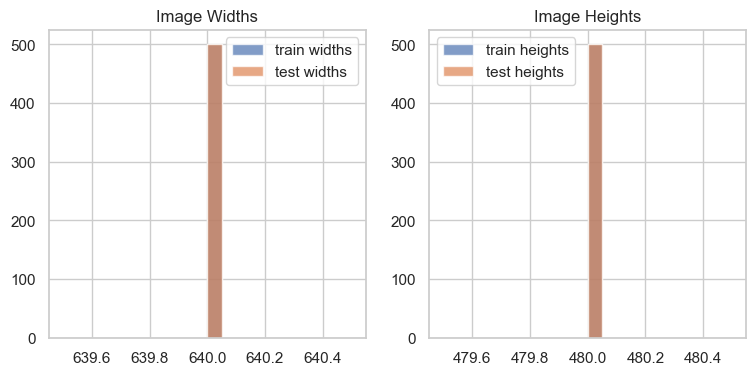

In [4]:
def get_image_sizes(dataset, max_samples=500):
    widths, heights = [], []
    count = 0
    for i in range(len(dataset)):
        row = dataset.dish_df.iloc[i]
        dish_id = row['dish_id']
        img_path = os.path.join(IMAGES_ROOT, str(dish_id), 'rgb.png')
        if os.path.exists(img_path):
            try:
                with Image.open(img_path) as im:
                    w, h = im.size
                    widths.append(w)
                    heights.append(h)
                    count += 1
                    if count >= max_samples:
                        break
            except Exception as e:
                continue
    return widths, heights

train_w, train_h = get_image_sizes(train_dataset)
test_w, test_h = get_image_sizes(test_dataset)

sns.set(style='whitegrid')
plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plt.hist(train_w, bins=20, alpha=0.7, label='train widths')
plt.hist(test_w, bins=20, alpha=0.7, label='test widths', color='C1')
plt.title('Image Widths')
plt.legend()
plt.subplot(1,2,2)
plt.hist(train_h, bins=20, alpha=0.7, label='train heights')
plt.hist(test_h, bins=20, alpha=0.7, label='test heights', color='C1')
plt.title('Image Heights')
plt.legend()
plt.show()


## Number of Words in Description

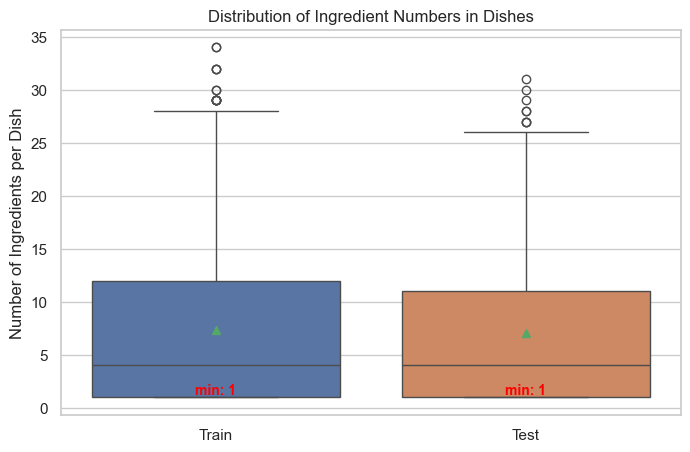

In [5]:
def description_lengths(dataset):
    lengths = []
    for i in range(len(dataset)):
        row = dataset.dish_df.iloc[i]
        ingr_str = row['ingredients']
        if isinstance(ingr_str, str) and ingr_str.strip():
            words = ingr_str.split(';')
            lengths.append(len(words))
    return lengths

train_desc = description_lengths(train_dataset)
test_desc = description_lengths(test_dataset)
plt.figure(figsize=(8,5))
sns.boxplot(data=[train_desc, test_desc], showmeans=True)
plt.xticks([0,1],['Train','Test'])
plt.ylabel('Number of Ingredients per Dish')
plt.title('Distribution of Ingredient Numbers in Dishes')
# Получаем минимумы
mins = [min(train_desc), min(test_desc)]

# Добавляем подписи минимума
for i, minimum in enumerate(mins):
    plt.text(i, minimum, f"min: {minimum}", ha='center', va='bottom', fontsize=10, color='red', fontweight='bold')
plt.show()


## Ingredient Duplicates Analysis

In [6]:
duplicates = ingr_df[ingr_df.duplicated(['ingr'], keep=False)]
if not duplicates.empty:
    print(f'Duplicate ingredient names found ({len(duplicates)}):')
    display(duplicates.sort_values('ingr'))
else:
    print('No duplicate ingredient names found.')


Duplicate ingredient names found (4):


,id,ingr
230,231,deprecated
452,453,deprecated
457,458,deprecated
469,470,deprecated


## Number of ingredients and most common Ingredients

Number of ingrediends in dataset: 555


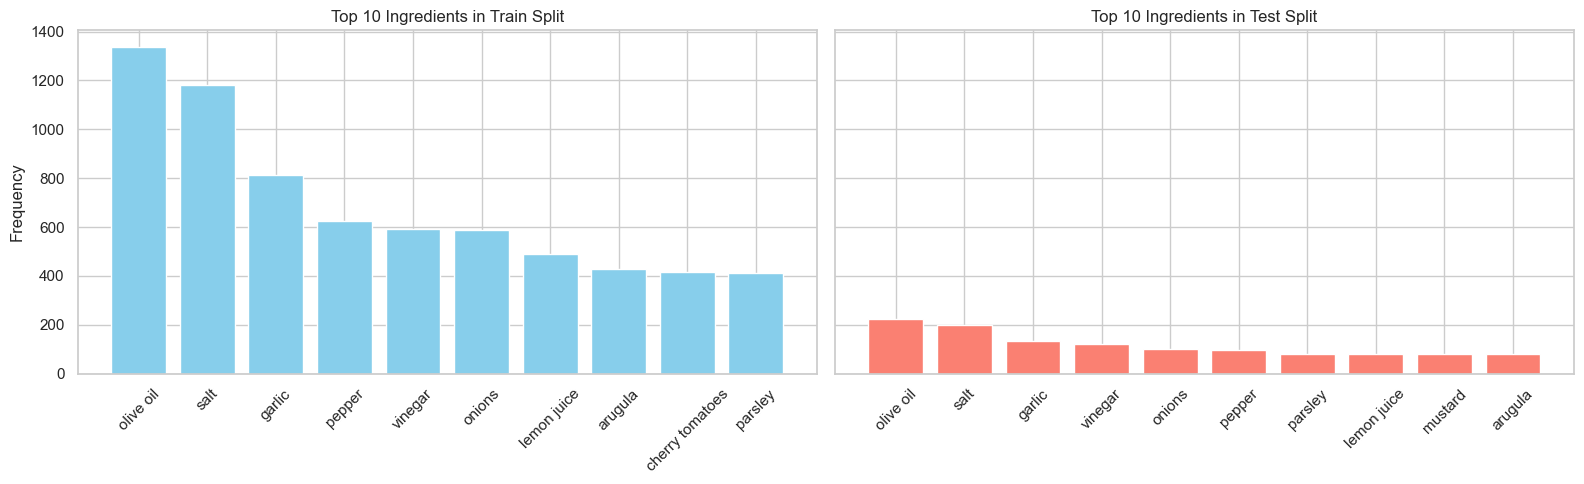

In [7]:
def ingr_frequency_names(dish_df, split, id2ingr):
    ingr_list = []
    for ingr_str in dish_df[dish_df['split']==split]['ingredients']:
        if isinstance(ingr_str, str) and ingr_str.strip():
            ingr_list.extend([i.strip() for i in ingr_str.split(';') if i.strip()])
    ids = [int(s.split('_')[-1]) for s in ingr_list if s.startswith('ingr_')]
    # Преобразуем id к названию ингредиента
    
    ingr_names = [id2ingr.get(i, f"ingr_{i}") for i in ids]
    return Counter(ingr_names)

id2ingr = dict(zip(ingr_df['id'], ingr_df['ingr']))
freq_train = ingr_frequency_names(dish_df, 'train', id2ingr)
freq_test = ingr_frequency_names(dish_df, 'test', id2ingr)

print('Number of ingrediends in dataset:', len(id2ingr))

# Гистограммы для train и test
fig, axs = plt.subplots(1, 2, figsize=(16,5), sharey=True)

# Train
ingredients_train, counts_train = zip(*freq_train.most_common(10))
axs[0].bar(ingredients_train, counts_train, color='skyblue')
axs[0].set_title('Top 10 Ingredients in Train Split')
axs[0].set_ylabel('Frequency')
axs[0].tick_params(axis='x', rotation=45)

# Test
ingredients_test, counts_test = zip(*freq_test.most_common(10))
axs[1].bar(ingredients_test, counts_test, color='salmon')
axs[1].set_title('Top 10 Ingredients in Test Split')
axs[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


## Target research

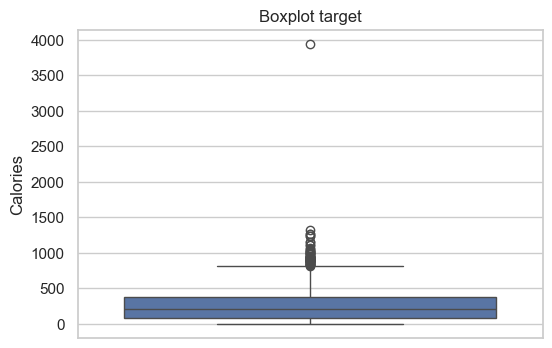

In [8]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=dish_df, y='total_calories')
plt.title('Boxplot target')
plt.ylabel('Calories')
plt.show()

# Augmentation

## Visual Augmentations

For images, we apply a standard set of visual augmentations:

- **RandomResizedCrop**
- **Horizontal Flip**
- **Small Rotations**:
  Rotation is acceptable because the orientation of a dish does not carry semantic information about its caloric content. In real-world scenarios, the camera angle may vary.

- **Moderate ColorJitter**

These augmentations improve robustness to scale, lighting conditions, and framing variations, without distorting the essential characteristics of the meal.

---

## Text Modality Augmentations

For the text modality (ingredient lists), we use two augmentations:

- **Shuffling**:
  Removes any unintended dependence on ingredient order.

- **Ingredient Dropout**:
  Makes the model robust to incomplete or noisy ingredient lists.

> Since ingredients act as a set of tags rather than natural language text, we implement custom augmentation logic instead of relying on general-purpose NLP libraries.


# Train model

In [18]:
from src.train import train, load_cfg

cfg = load_cfg("config/effinet_multihot.yaml")
results = train(cfg)
results

Epoch 1/20:   0%|          | 0/78 [00:00<?, ?it/s]/Users/borisfox/Documents/ML/nn/sprint 4/project/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:1118: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Epoch 001 | train MAE: 128.2824 | val MAE: 91.1358 | lr: 9.94e-04


Epoch 002 | train MAE: 81.1335 | val MAE: 72.4295 | lr: 9.76e-04


Epoch 003 | train MAE: 70.9047 | val MAE: 110.3278 | lr: 9.46e-04


Epoch 004 | train MAE: 65.9109 | val MAE: 68.3345 | lr: 9.05e-04


Epoch 005 | train MAE: 62.2165 | val MAE: 74.2865 | lr: 8.54e-04


Epoch 006 | train MAE: 59.5792 | val MAE: 52.3156 | lr: 7.94e-04


Epoch 007 | train MAE: 51.8082 | val MAE: 82.6436 | lr: 7.27e-04


Epoch 008 | train MAE: 55.8780 | val MAE: 51.4717 | lr: 6.55e-04


Epoch 009 | train MAE: 51.7975 | val MAE: 57.0625 | lr: 5.78e-04


Epoch 010 | train MAE: 50.5966 | val MAE: 44.2399 | lr: 5.00e-04


Epoch 011 | train MAE: 47.2395 | val MAE: 47.1773 | lr: 4.22e-04


Epoch 012 | train MAE: 46.6291 | val MAE: 45.7784 | lr: 3.45e-04


Epoch 013 | train MAE: 41.0713 | val MAE: 44.5657 | lr: 2.73e-04


Epoch 014 | train MAE: 41.4798 | val MAE: 39.2811 | lr: 2.06e-04


Epoch 015 | train MAE: 39.9240 | val MAE: 42.8079 | lr: 1.46e-04


Epoch 016 | train MAE: 38.7405 | val MAE: 36.5229 | lr: 9.55e-05


Epoch 017 | train MAE: 37.7297 | val MAE: 36.9629 | lr: 5.45e-05


Epoch 018 | train MAE: 37.1415 | val MAE: 37.8982 | lr: 2.45e-05


Epoch 019 | train MAE: 36.8049 | val MAE: 39.3884 | lr: 6.16e-06


Epoch 020 | train MAE: 36.0135 | val MAE: 38.4831 | lr: 0.00e+00
TEST MAE: 64.9122


{'best_val_mae': 36.52285955255682,
 'test_mae': 64.91220809063732,
 'best_checkpoint': 'outputs/run_effnet_multihot/checkpoints/best_epoch_016_valMAE_36.5229.pt',
 'metrics_path': 'outputs/run_effnet_multihot/metrics.yaml'}

Учил на своем ноуте, поэтому эпох мало. ВМ Яндекса, постоянно падает.

# Inference

In [19]:
from src.infer import predict_on_test
import numpy as np

CHECKPOINT_PATH = './outputs/run_effnet_multihot/checkpoints/best_model.pt'  
all_preds, all_targets, all_idxs, test_mae, test_ds, dish_df = predict_on_test(CHECKPOINT_PATH, data_dir='./data', device='cpu')

print(f"Test MAE: {test_mae:.4f}")

# Top-5 most errors
errors = np.abs(all_preds - all_targets)
top5_idx = np.argsort(errors)[-5:][::-1]  
for rank, idx in enumerate(top5_idx, 1):
    data_idx = all_idxs[idx]
    dish_row = dish_df[dish_df['dish_id'] == data_idx]
    print(f"#{rank}: {dish_row['dish_id']} -- True={all_targets[idx]:.2f}, Pred={all_preds[idx]:.2f}, Err={errors[idx]:.2f}")

Test MAE: 64.9122
#1: 949    dish_1565811139
Name: dish_id, dtype: str -- True=902.20, Pred=499.92, Err=402.28
#2: 771    dish_1560526552
Name: dish_id, dtype: str -- True=359.24, Pred=723.35, Err=364.11
#3: 2390    dish_1558376483
Name: dish_id, dtype: str -- True=735.03, Pred=1089.37, Err=354.34
#4: 1816    dish_1566501575
Name: dish_id, dtype: str -- True=251.69, Pred=594.91, Err=343.22
#5: 622    dish_1563389626
Name: dish_id, dtype: str -- True=498.62, Pred=175.01, Err=323.61


The biggest mistakes are observed in salads, which is understandable - a large number of ingredients are mixed together.